## Get payout history w.r.t to price and see how the overall profit is affected given price change. 
 - Assuming that the user does not sell ETH and re-buy it.

In [1]:
import pandas as pd
import requests
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib

plt.style.use("seaborn")

In [2]:
wallet = "A974d019AE1498A7367750407813a9CC67d404Fa" # Random address found on ethermine
api_base = f"https://api.ethermine.org"
api_payouts = f"{api_base}/miner/{wallet}/payouts"

In [3]:
payload, headers = {}, {}

# request
response = requests.request("GET", api_payouts, headers=headers, data=payload)


In [4]:
payouts = pd.DataFrame(response.json()["data"])
payouts["amount"] = payouts["amount"]/10e18 # Convert from Gwei to Ether
payouts


,start,end,amount,txHash,paidOn
0,13881569,13888017,0.083507,0x453d39d146405151c835ccbfd6181154a66c173ec313...,1640618080
1,13875063,13881525,0.082202,0x135b38755687225761c5915ba88f5730ca02929c208c...,1640531442
2,13868581,13875030,0.082253,0xefd0d7973e3f25b0e45c236f70d5bebaaf1101e680ae...,1640444630
3,13862106,13868537,0.087789,0x6f56235da2e91cd5a751c009cd9b86c74fd64045688c...,1640357952
4,13855655,13862071,0.081634,0x1d5cd2dd524ebbd50d7c43e03f6701d62abda18eecea...,1640271286
...,...,...,...,...,...
76,13389757,13396184,0.075013,0x4098cce97840f9db1ef448321962b1c833ecc0bbafc8...,1633940336
77,13383273,13389715,0.075158,0x1d5494c6d44aec4c9d94eea9e05744ed9aca6e394919...,1633853058
78,13376582,13383230,0.075039,0x921bf2462da69e93fb7d7383c6a8fd833eca7714ff96...,1633765236
79,13370109,13376534,0.080336,0x611a65b3e6712fd3db30751a438ffb76dd52145614b6...,1633674110


In [5]:
time_now = int(np.floor(datetime.now().timestamp()))
time_then = payouts.paidOn.min()


In [6]:
time_then, time_now

(1633586324, 1640622112)

In [7]:
url = f"https://api.woo.org/tv/history?symbol=ETH_USDT&resolution=1D&from={time_then}&to={time_now}" # WooX Exchange price history (based on their volume)

In [8]:
# request
response = requests.request("GET", url, headers=headers, data=payload)
eth_price = response.json()

In [9]:
eth = pd.DataFrame()
eth["price"] = eth_price["c"]
eth["time"] = eth_price["t"]
eth["time"] = pd.to_datetime(eth["time"], unit="s")


In [10]:
payouts["paidOn"] = pd.to_datetime(payouts["paidOn"], unit="s")


In [11]:
payouts.paidOn = payouts.paidOn.dt.strftime('%Y/%m/%d')
payouts["paidOn"] = pd.to_datetime(payouts["paidOn"])
payouts.sort_values(by="paidOn", inplace=True)
eth.sort_values(by="time", inplace=True)


In [12]:
joined = pd.merge(left=eth, right=payouts, left_on="time",
                  right_on="paidOn", how="inner")


In [13]:
diff = (eth['price'].values[-1] - joined.price.mean())
pct = diff/joined.price.mean()*100
print(f"Difference from average payout price {np.round(diff,2)} $")
print(f"Percentage from average payout price {np.round(pct,2)} %")


Difference from average payout price -83.72 $
Percentage from average payout price -2.01 %


In [14]:
def custom_plot(df: pd.DataFrame, ax: matplotlib.axes, metric: str = "stdev", reduced: bool = None, reduced_factor: int = 2):
    ax.grid("both")
    ax.plot(df.paidOn, df.price, label="ETH price",
            color="black", linewidth=0.5, marker=".")
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Price", fontsize=12)
    if metric in {"stdev", "std"}:
        if not reduced:
            std = df.price.std()
            ax.axhline(df.price.mean()+std,
                       color='green', label=f"+1 σ")
            ax.fill_between(x=df.paidOn, y1=df.price, y2=df.price.mean() + std, where=df.price >= df.price.mean() + std,
                            alpha=0.3, facecolor='green', interpolate=True)
            ax.axhline(df.price.mean()-std,
                       color='red', label=f"-1 σ")
            ax.fill_between(x=df.paidOn, y1=df.price, y2=df.price.mean() - std, where=df.price <= df.price.mean() - std,
                            alpha=0.3, facecolor='red', interpolate=True)
        else:
            std = df.price.std()/reduced_factor
            for i in range(1, reduced_factor+1):
                alpha = 0.3*i if i <= 3 else 0.95
                color_red = "red" if i <= 3 else "black"
                color_green = "green" if i <= 3 else "black"
                ax.axhline(df.price.mean()+i*std,
                           color=color_green, label=f"+{i} σ")
                ax.fill_between(x=df.paidOn, y1=df.price, y2=df.price.mean() + i*std, where=df.price >= df.price.mean() + i*std,
                                alpha=alpha, facecolor=color_green, interpolate=True)
                ax.axhline(df.price.mean()-i*std,
                           color=color_red, label=f"-{i} σ")
                ax.fill_between(x=df.paidOn, y1=df.price, y2=df.price.mean() - i*std, where=df.price <= df.price.mean() - i*std,
                                alpha=alpha, facecolor=color_red, interpolate=True)
        ax.axhline(df.price.mean(), color="black",
                   label="Mean payout price")

    ax.legend(fontsize=12)
    for i, txt in enumerate(df["amount"].values.round(6)):
        ax.annotate(txt, (df.paidOn.values[i], df.price.values[i]),
                    horizontalalignment='right', verticalalignment='top')
    return ax


### Plot of Eth price vs payout amount. 
  - Note `reduced` is set to `False`

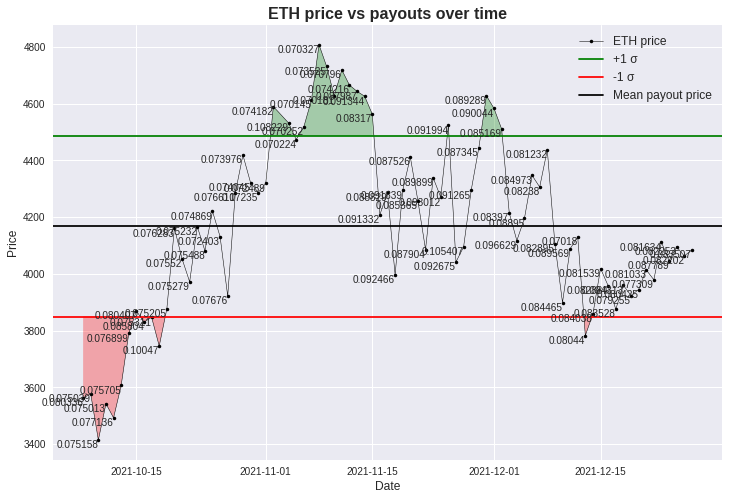

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
custom_plot(df=joined, ax=ax, reduced=False)
ax.set_title("ETH price vs payouts over time", fontsize=16, fontweight="bold")
plt.show()


### Plot of ETH price vs payout amount. 
 - Note `reduced` is `True` and `reduced_factor` is `2`, which means that `σ` is now `σ/2`

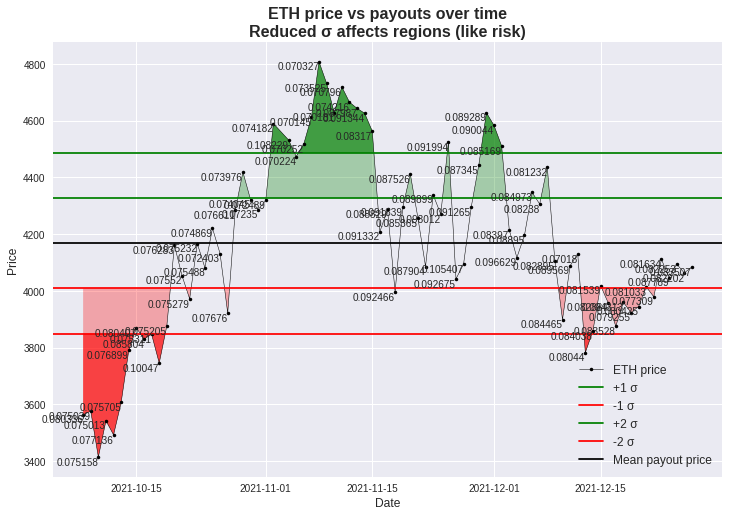

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
custom_plot(df=joined, ax=ax, reduced=True, reduced_factor=2)
ax.set_title("ETH price vs payouts over time\nReduced σ affects regions (like risk)",
             fontsize=16, fontweight="bold")
plt.show()
